In [11]:
import pymbar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import zip_longest
from pymbar import timeseries 

In [12]:
# Constants.
kB = 1.381e-23 * 6.022e23 / 1000.0 / 4.184 # Boltzmann constant in kcal/mol/K

In [13]:
df = pd.read_pickle("./evb.pkl")

df = df.astype({col: float for col in df.columns[1:]})
df.dropna(how='any', inplace=True)
df['rc0'] = [float(label.split('_')[-1]) for label in df.label]
df

,label,step,time,H11,H12,H22,vec_0,vec_1,RC,rc0
0,evb_000_rc_-0.60,1.0,0.0005,-54.544331,11.5,-72.000780,-0.444654,0.895703,-0.053911,-0.6
1,evb_000_rc_-0.60,2.0,0.0010,-56.295613,11.5,-68.786434,-0.511252,0.859431,-0.191057,-0.6
2,evb_000_rc_-0.60,3.0,0.0015,-52.943731,11.5,-61.865011,-0.564964,0.825115,-0.419825,-0.6
3,evb_000_rc_-0.60,4.0,0.0020,-36.142295,11.5,-55.035216,-0.427352,0.904085,-0.679999,-0.6
4,evb_000_rc_-0.60,5.0,0.0025,-5.344831,11.5,-53.228973,-0.222027,0.975041,-0.905472,-0.6
...,...,...,...,...,...,...,...,...,...,...
12499995,evb_024_rc_0.60,499996.0,249.9980,3.906990,11.5,-80.925665,-0.131992,0.991251,0.598637,0.6
12499996,evb_024_rc_0.60,499997.0,249.9985,3.683211,11.5,-80.773398,-0.132550,0.991176,0.607135,0.6
12499997,evb_024_rc_0.60,499998.0,249.9990,3.323395,11.5,-80.700728,-0.133196,0.991090,0.614889,0.6
12499998,evb_024_rc_0.60,499999.0,249.9995,2.670315,11.5,-80.738335,-0.134127,0.990964,0.618802,0.6


(-1.5, 1.5)

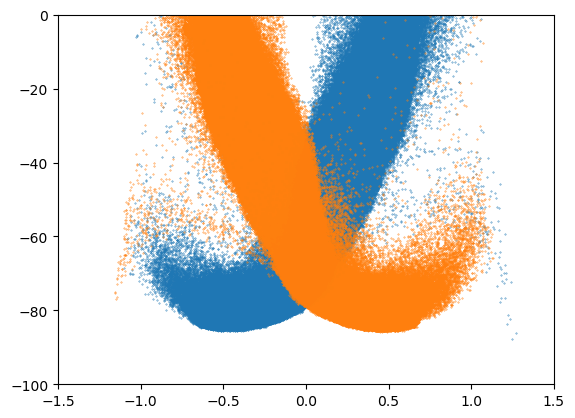

In [14]:
plt.scatter(df.RC, df.H11,s=.1)
plt.scatter(df.RC, df.H22,s=.1)
plt.ylim([-100, 0])
plt.xlim([-1.5, 1.5])

The ground state EVB potential
$$
E_g = \frac{1}{2} \left( H_{11} + H_{22} - \sqrt{(H_{11} - H_{22})^2 + 4H_{12}^2} \right)
$$
The umbrella biased potential, k = 400 kcal/(mol*A$^2$)
$$
V_{umb}(RC) = \frac{1}{2} k [RC - RC_0 ]^2 = E_{bias}(RC, RC_0)
$$
The mapped potential 
$$
E_m(\xi, \lambda) = E_g(\xi) + E_{bias}(\xi, \lambda)
$$
Free energy difference, R=1.987 cal/(K mol), T=300K, RT=0.596 kcal/mol
$$
\Delta G_m (\lambda_k) = \Delta G_m(\lambda_0 \rightarrow \lambda_k) = \sum_{i=0}^{k-1} -RT \ln \left< e^{-\frac{E_m(\lambda_{i+1}) - E_m(\lambda_i)}{RT}} \right>_{m_i}
$$


In [15]:
def cal_eg(H11, H22, H12): 
    return 0.5 * (H11 + H22 - np.sqrt((H11-H22)**2 + 4*H12**2))
df['Eg'] = [cal_eg(H11, H22, H12) for H11, H22, H12 in zip(df.H11, df.H22, df.H12)]

In [16]:
def cal_eb(rc, rc0, k=400): 
    return 0.5 * k * (rc - rc0)**2
df['Eb'] = [cal_eb(rc, rc0) for rc, rc0 in zip(df.RC, df.rc0)]

In [17]:
df['Em'] = df.Eg + df.Eb

(-1.5, 1.5)

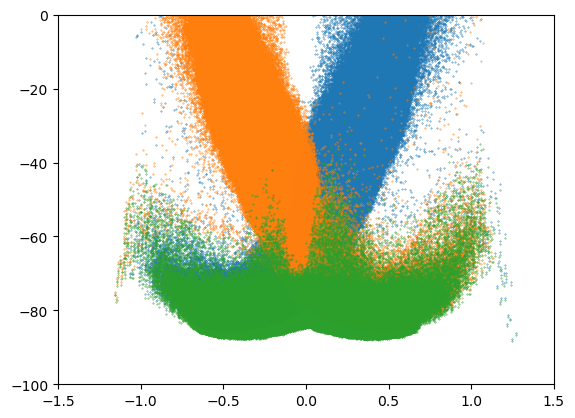

In [18]:
plt.scatter(df.RC, df.H11,s=.1)
plt.scatter(df.RC, df.H22,s=.1)
plt.scatter(df.RC, df.Eg,s=.1)
plt.ylim([-100, 0])
plt.xlim([-1.5, 1.5])

In [19]:
hist, bin_edges = np.histogram(df.RC, bins=100, range=[-.8, .8])
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
inds = np.digitize(df.RC, bin_edges)

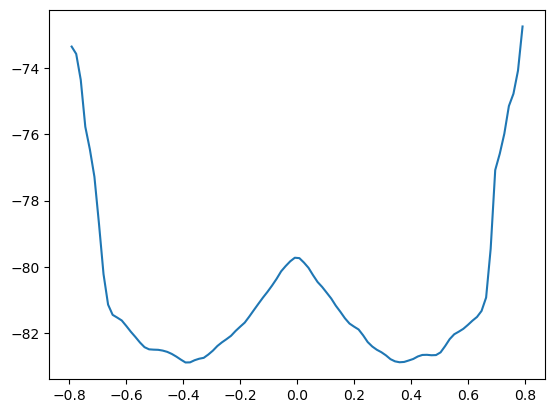

In [20]:
Eg_hist = np.zeros(len(set(inds)))
for ind, enrg in zip(inds, df.Eg): 
    Eg_hist[ind] += enrg

Eg_hist = Eg_hist[1:-1] / hist

plt.plot(bin_centers, Eg_hist)